# Importing Libraries

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, classification_report, 
                             accuracy_score,precision_score, recall_score, f1_score,roc_curve, auc, precision_recall_curve, 
                             average_precision_score)

%matplotlib inline

# Reading in and Cleaning Contracts Data

Reading in our main dataset with all recent WR contracts.

In [2]:
wr_contracts = pd.read_csv("WR_Contracts.csv", header=None)

In [3]:
wr_contracts.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Tyreek Hill,Dolphins,2022,4.0,NaN,"$120,000,000","$30,000,000","$72,200,000",NaN,14.40%,NaN,"$129,567,723","$32,391,931","$77,956,580"
1,Jerry Rice,49ers,1996,5.0,NaN,"$29,000,000","$5,800,000","$4,000,000",NaN,14.20%,NaN,"$159,968,591","$31,993,718","$22,064,633"
2,DeAndre Hopkins,Cardinals,2020,2.0,NaN,"$54,500,000","$27,250,000","$49,400,000",NaN,13.70%,NaN,"$61,814,329","$30,907,164","$56,029,869"
3,Randy Moss,Vikings,2001,7.0,NaN,"$63,536,000","$9,076,571","$18,000,000",NaN,13.50%,NaN,"$211,896,637","$30,270,947","$60,031,155"
4,Davante Adams,Raiders,2022,5.0,NaN,"$140,000,000","$28,000,000","$65,710,000",NaN,13.40%,NaN,"$151,162,344","$30,232,469","$70,949,126"


Dropping extra columns.

In [4]:
wr_contracts.drop([4,8,10], axis=1, inplace=True)

Changing our column names.

In [5]:
wr_contracts.columns = ['player', 'team', 'year_signed', 'years', 'value', 'apy', 'guaranteed', 
                        'apy_as_perc_of_cap_at_sign', 'inflated_value', 'inflated_apy', 'inflated_guarantee']

In [6]:
wr_contracts.head()

,player,team,year_signed,years,value,apy,guaranteed,apy_as_perc_of_cap_at_sign,inflated_value,inflated_apy,inflated_guarantee
0,Tyreek Hill,Dolphins,2022,4.0,"$120,000,000","$30,000,000","$72,200,000",14.40%,"$129,567,723","$32,391,931","$77,956,580"
1,Jerry Rice,49ers,1996,5.0,"$29,000,000","$5,800,000","$4,000,000",14.20%,"$159,968,591","$31,993,718","$22,064,633"
2,DeAndre Hopkins,Cardinals,2020,2.0,"$54,500,000","$27,250,000","$49,400,000",13.70%,"$61,814,329","$30,907,164","$56,029,869"
3,Randy Moss,Vikings,2001,7.0,"$63,536,000","$9,076,571","$18,000,000",13.50%,"$211,896,637","$30,270,947","$60,031,155"
4,Davante Adams,Raiders,2022,5.0,"$140,000,000","$28,000,000","$65,710,000",13.40%,"$151,162,344","$30,232,469","$70,949,126"


Dropping unnesccesary data

In [7]:
wr_contracts.drop(['inflated_value','inflated_apy','inflated_guarantee','apy_as_perc_of_cap_at_sign','team'], 
                  axis=1, inplace=True)

Checking what years we have data for.

In [8]:
wr_contracts['year_signed'].value_counts()

2022    789
2021    688
2020    584
2019    578
2018    577
2017    557
2016    267
2015    193
0       167
2014    143
2023    130
2013     91
2012     91
2011     68
2010     32
2009     21
2008     21
2005     15
2007     15
2006     12
2004      8
2001      5
2003      4
2002      3
1996      3
1994      3
1998      3
1995      2
1999      1
2000      1
1997      1
1993      1
1991      1
1992      1
1988      1
1990      1
1985      1
Name: year_signed, dtype: int64

Dropping data before 2010 since we don't have enough data before then, along with any duplicates.

In [9]:
wr_contracts = wr_contracts[wr_contracts['year_signed'] > 2010]

In [10]:
wr_contracts = wr_contracts.drop_duplicates()

In [11]:
wr_contracts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4172 entries, 0 to 5078
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   player       4172 non-null   object 
 1   year_signed  4172 non-null   int64  
 2   years        4171 non-null   float64
 3   value        4172 non-null   object 
 4   apy          4172 non-null   object 
 5   guaranteed   4172 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 228.2+ KB


Dropping our row with a null value.

In [12]:
wr_contracts.dropna(inplace=True)

Changing our year's column from float to int.

In [13]:
wr_contracts['years'] = wr_contracts['years'].astype(int)

Removing the $ from the money columns and making them integers.

In [14]:
money_cols = ['value', 'apy', 'guaranteed']
for column in money_cols:
    wr_contracts[column] = wr_contracts[column].str.replace('$', '').str.replace(',', '').astype(int)

C:\Users\Owner\AppData\Local\Temp\ipykernel_36788\586175508.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  wr_contracts[column] = wr_contracts[column].str.replace('$', '').str.replace(',', '').astype(int)


In [15]:
wr_contracts_all_years = wr_contracts.copy()

Taking each contract and adding a row for each year of the contract (instead of one row per contract).

In [16]:
for index, row in wr_contracts.iterrows():
    for num in range(row['years']-1):
        copy = row.copy()
        copy['year_signed'] = copy['year_signed'] + num + 1
        copy_df = pd.DataFrame(copy).transpose()
        wr_contracts_all_years = pd.concat([wr_contracts_all_years, copy_df])

Dropping any duplicates.

In [17]:
wr_contracts_all_years = wr_contracts_all_years.drop_duplicates()

In [18]:
wr_contracts_all_years.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7608 entries, 0 to 4287
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   player       7608 non-null   object
 1   year_signed  7608 non-null   object
 2   years        7608 non-null   object
 3   value        7608 non-null   object
 4   apy          7608 non-null   object
 5   guaranteed   7608 non-null   object
dtypes: object(6)
memory usage: 416.1+ KB


Ranking each contract by value, apy, and guaranteed money for each year.

In [19]:
wr_contracts_all_years['value_rank_by_year'] = wr_contracts_all_years.groupby('year_signed')['value'].rank(ascending=False)
wr_contracts_all_years['apy_rank_by_year'] = wr_contracts_all_years.groupby('year_signed')['apy'].rank(ascending=False)
wr_contracts_all_years['guaranteed_rank_by_year'] = wr_contracts_all_years.groupby('year_signed')['guaranteed'].rank(ascending=False)

Merging our original wr_contracts DF with our DF that contains all years and ranks. This will again give us a DF with one row per contract, but each contract will then be ranked among all contracts active in that year.

In [20]:
ranks = pd.merge(wr_contracts, wr_contracts_all_years, on=['player','year_signed','years','value','apy','guaranteed'], 
                 how='inner')

In [21]:
ranks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4171 entries, 0 to 4170
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player                   4171 non-null   object 
 1   year_signed              4171 non-null   object 
 2   years                    4171 non-null   object 
 3   value                    4171 non-null   object 
 4   apy                      4171 non-null   object 
 5   guaranteed               4171 non-null   object 
 6   value_rank_by_year       4171 non-null   float64
 7   apy_rank_by_year         4171 non-null   float64
 8   guaranteed_rank_by_year  4171 non-null   float64
dtypes: float64(3), object(6)
memory usage: 325.9+ KB


In [22]:
ranks.head()

,player,year_signed,years,value,apy,guaranteed,value_rank_by_year,apy_rank_by_year,guaranteed_rank_by_year
0,Tyreek Hill,2022,4,120000000,30000000,72200000,2.0,1.0,2.0
1,DeAndre Hopkins,2020,2,54500000,27250000,49400000,15.0,1.0,8.0
2,Davante Adams,2022,5,140000000,28000000,65710000,1.0,2.0,4.0
3,Calvin Johnson,2012,7,113450000,16207143,53250000,1.0,1.0,1.0
4,Larry Fitzgerald,2011,7,113000000,16142857,45000000,1.0,1.0,1.0


Creating a list with all our player names.

In [23]:
player_names = ranks['player'].unique().tolist()

Making a DF for every second contract each player has signed.

In [24]:
second_contracts = pd.DataFrame(columns=['player','year_signed','years','value','apy','guaranteed'])

Looping through our list of player names and creating a DF for each player. If that player has signed a contract after their rookie contract, we sort our player DF by year signed, take the second contract, and add that to our second_contracts DF.

In [25]:
for name in player_names:
    player_df = ranks[ranks['player']==name]
    if len(player_df) > 1:
        player_second_contract = pd.DataFrame(player_df.sort_values('year_signed',ascending=True).iloc[1]).transpose()
        second_contracts = pd.concat([second_contracts, player_second_contract])
    else:
        continue

Dropping all duplicates.

In [26]:
second_contracts = second_contracts.drop_duplicates()

In [27]:
second_contracts.head()

,player,year_signed,years,value,apy,guaranteed,value_rank_by_year,apy_rank_by_year,guaranteed_rank_by_year
30,Tyreek Hill,2019,3,54000000,18000000,35260000,17.0,3.5,13.0
26,DeAndre Hopkins,2017,5,81000000,16200000,49000000,3.0,3.0,2.0
47,Davante Adams,2017,4,58000000,14500000,18000000,11.0,6.0,28.5
62,Larry Fitzgerald,2015,2,22000000,11000000,22000000,39.0,12.5,17.5
57,Cooper Kupp,2020,3,47250000,15750000,35133000,21.0,17.0,13.0


# Reading in and Cleaning Stats Data

In [28]:
wr_stats = pd.read_csv('WR_Stats_Rookie_Soph_3rd_2006-2020.txt')

In [29]:
wr_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1792 entries, 0 to 1791
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Rk        1792 non-null   int64  
 1   Player    1792 non-null   object 
 2   FantPt    1536 non-null   float64
 3   Tgt       1792 non-null   int64  
 4   Season    1792 non-null   int64  
 5   Age       1792 non-null   int64  
 6   Team      1792 non-null   object 
 7   G         1792 non-null   int64  
 8   GS        1792 non-null   int64  
 9   FantPt.1  1536 non-null   float64
 10  PPR       1536 non-null   float64
 11  FantPt.2  1536 non-null   float64
 12  PPR/G     1536 non-null   float64
 13  Tgt.1     1792 non-null   int64  
 14  Rec       1792 non-null   int64  
 15  Yds       1792 non-null   int64  
 16  Y/R       1516 non-null   float64
 17  TD        1792 non-null   int64  
 18  Y/G       1791 non-null   float64
 19  Ctch%     1617 non-null   float64
 20  Y/Tgt     1617 non-null   floa

Dropping unnecessary data.

In [30]:
wr_stats.drop(['Rk', 'FantPt', 'Team', 'FantPt.1', 'PPR', 'FantPt.2', 'PPR/G', 'Tgt.1', 'Pos', '-9999'], axis=1, inplace=True)

In [31]:
wr_stats.head()

,Player,Tgt,Season,Age,G,GS,Rec,Yds,Y/R,TD,Y/G,Ctch%,Y/Tgt,1D,Draft
0,Josh Gordon,159,2013,22,14,14,87,1646,18.9,9,117.6,54.7,10.4,64.0,2-1
1,Allen Robinson,151,2015,22,16,16,80,1400,17.5,14,87.5,53.0,9.3,61.0,2-61
2,Odell Beckham Jr.,158,2015,23,15,15,96,1450,15.1,13,96.7,60.8,9.2,68.0,1-12
3,Victor Cruz,131,2011,25,16,7,82,1536,18.7,9,96.0,62.6,11.7,59.0,NaN
4,Odell Beckham Jr.,130,2014,22,12,11,91,1305,14.3,12,108.8,70.0,10.0,58.0,1-12


Our Draft column is currently in Round-Pick Number format. We just want their pick number.

In [32]:
wr_stats['Draft'] = wr_stats['Draft'].str[2:]

Currently our undrafted players are in as null, let's look to find a proper value for them by finding our max non-null value.

In [33]:
max(wr_stats[wr_stats['Draft'].isnull()==False]['Draft'].astype(int))

256

Let's assign them 260, just over the last pick in the draft.

In [34]:
wr_stats['Draft'].fillna(260, inplace=True)

Let's create a new players' names list with our stats DF. Right now our DF has an individual row for each player's rookie, sophmore, and third season. We want to combine all three seasons in one row.

In [35]:
player_names = wr_stats['Player'].unique().tolist()

Creating our new DF.

In [36]:
combined_stats = pd.DataFrame(columns=['Player','Rookie Tgt', 'Rookie Season', 'Rookie Age', 'Rookie G',  'Rookie GS',
                       'Rookie Rec','Rookie Yds','Rookie Y/R','Rookie TD', 'Rookie Y/G', 
                        'Rookie Ctch%','Rookie Y/Tgt', 'Rookie 1D','Draft', 'Soph Tgt', 'Soph Season', 'Soph Age', 'Soph G', 
                        'Soph GS','Soph Rec','Soph Yds','Soph Y/R','Soph TD','Soph Y/G','Soph Ctch%','Soph Y/Tgt','Soph 1D', 
                        'Y3 Tgt', 'Y3', 'Y3 Age', 'Y3 G', 'Y3 GS','Y3 Rec','Y3 Yds','Y3 Y/R','Y3 TD','Y3 Y/G', 
                       'Y3 Ctch%', 'Y3 Y/Tgt','Y3 1D'])

Looping through our list of names and creating a DF for each player. For all players that have played their first 3 seasons, we sort their DF by season, take each season, and rename the columns to indicate the correct year in their career. We drop unnecessary columns (like player name and draft) and combine all seasons to one row in our new DF. 

In [37]:
for name in player_names:
    player_df = wr_stats[wr_stats['Player'] == name]
    if len(player_df) == 3:
        rookie = player_df.sort_values('Season', ascending=True).iloc[0]
        rookie.rename({'Tgt': 'Rookie Tgt', 'Season': 'Rookie Season', 'Age':'Rookie Age', 'G':'Rookie G', 'GS': 'Rookie GS',
                       'Rec':'Rookie Rec','Yds':'Rookie Yds','Y/R':'Rookie Y/R','TD':'Rookie TD','Y/G': 'Rookie Y/G', 
                       'Ctch%': 'Rookie Ctch%','Y/Tgt':'Rookie Y/Tgt','1D':'Rookie 1D'}, inplace=True)
        soph = player_df.sort_values('Season', ascending=True).iloc[1]
        soph.rename({'Tgt': 'Soph Tgt', 'Season': 'Soph Season', 'Age':'Soph Age', 'G':'Soph G', 'GS': 'Soph GS',
                       'Rec':'Soph Rec','Yds':'Soph Yds','Y/R':'Soph Y/R','TD':'Soph TD','Y/G': 'Soph Y/G', 
                       'Ctch%': 'Soph Ctch%','Y/Tgt':'Soph Y/Tgt', '1D':'Soph 1D'}, inplace=True)
        soph.drop(['Player','Draft'], inplace=True)
        y3 = player_df.sort_values('Season', ascending=True).iloc[2]
        y3.rename({'Tgt': 'Y3 Tgt', 'Season': 'Y3', 'Age':'Y3 Age', 'G':'Y3 G', 'GS': 'Y3 GS',
                       'Rec':'Y3 Rec','Yds':'Y3 Yds','Y/R':'Y3 Y/R','TD':'Y3 TD','Y/G': 'Y3 Y/G', 
                       'Ctch%': 'Y3 Ctch%','Y/Tgt':'Y3 Y/Tgt','1D':'Y3 1D'}, inplace=True)
        y3.drop(['Player','Draft'], inplace=True)
        combined_player = pd.DataFrame(pd.concat([rookie,soph,y3])).transpose()
        combined_stats = pd.concat([combined_stats, combined_player])
    else:
        continue

In [38]:
combined_stats.head()

,Player,Rookie Tgt,Rookie Season,Rookie Age,Rookie G,Rookie GS,Rookie Rec,Rookie Yds,Rookie Y/R,Rookie TD,...,Y3 G,Y3 GS,Y3 Rec,Y3 Yds,Y3 Y/R,Y3 TD,Y3 Y/G,Y3 Ctch%,Y3 Y/Tgt,Y3 1D
0,Josh Gordon,96,2012,21,16,13,50,805,16.1,5,...,5,5,24,303,12.6,0,60.6,51.1,6.4,16.0
0,Allen Robinson,81,2014,21,10,8,48,548,11.4,2,...,16,16,73,883,12.1,6,55.2,48.3,5.8,51.0
0,Odell Beckham Jr.,130,2014,22,12,11,91,1305,14.3,12,...,16,16,101,1367,13.5,10,85.4,59.8,8.1,66.0
0,Calvin Johnson,93,2007,22,15,10,48,756,15.8,4,...,14,14,67,984,14.7,5,70.3,48.9,7.2,46.0
0,A.J. Green,115,2011,23,15,15,65,1057,16.3,7,...,16,16,98,1426,14.6,11,89.1,55.1,8.0,65.0


# Merging our DFs Together and Creating our Final DF

We now merge this DF with our second contracts DF. Now we have each player who signed a second contract, with the rank of their contract in terms of monetary value across all contracts that year, and the stats they had in their first 3 seasons.

In [39]:
df = pd.merge(second_contracts, combined_stats, how='inner', left_on='player', right_on='Player')

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265 entries, 0 to 264
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   player                   265 non-null    object
 1   year_signed              265 non-null    object
 2   years                    265 non-null    object
 3   value                    265 non-null    object
 4   apy                      265 non-null    object
 5   guaranteed               265 non-null    object
 6   value_rank_by_year       265 non-null    object
 7   apy_rank_by_year         265 non-null    object
 8   guaranteed_rank_by_year  265 non-null    object
 9   Player                   265 non-null    object
 10  Rookie Tgt               265 non-null    object
 11  Rookie Season            265 non-null    object
 12  Rookie Age               265 non-null    object
 13  Rookie G                 265 non-null    object
 14  Rookie GS                265 non-null    o

Since we will be trying to determing whether a GM will have to pay a WR a top 10 contract, lets create our buckets for that.

In [41]:
df['value_bucket'] = np.where(df['value_rank_by_year']<=10, 1,0)
df['apy_bucket'] = np.where(df['apy_rank_by_year']<=10, 1,0)
df['guaranteed_bucket'] = np.where(df['guaranteed_rank_by_year']<=10, 1,0)

# Classification

Choosing target and feature variables.

In [402]:
X = df[['Rookie Tgt', 'Rookie Season', 'Rookie Age','Rookie G','Rookie GS', 'Rookie Rec', 'Rookie Yds','Rookie TD','Rookie Y/G',
      'Draft', 'Soph Tgt','Soph G','Soph GS', 'Soph Rec', 'Soph Yds','Soph TD','Soph Y/G','Y3 Tgt', 'Y3 G','Y3 GS',
       'Y3 Rec', 'Y3 Yds', 'Y3 TD','Y3 Y/G']]
y = df['apy_bucket']

Converting all feature variables to floats and our target variable to integers.

In [403]:
X = X.astype(float)
y = y.astype(int)

Looking to see if there are any highly correlated variables that could lead to multicolinearity.

In [404]:
X.corr()[X.corr() > .8]

,Rookie Tgt,Rookie Season,Rookie Age,Rookie G,Rookie GS,Rookie Rec,Rookie Yds,Rookie TD,Rookie Y/G,Draft,...,Soph Yds,Soph TD,Soph Y/G,Y3 Tgt,Y3 G,Y3 GS,Y3 Rec,Y3 Yds,Y3 TD,Y3 Y/G
Rookie Tgt,1.000000,NaN,NaN,NaN,0.847097,0.973195,0.962102,NaN,0.911183,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rookie Season,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rookie Age,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rookie G,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rookie GS,0.847097,NaN,NaN,NaN,1.000000,0.808450,0.816311,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rookie Rec,0.973195,NaN,NaN,NaN,0.808450,1.000000,0.964736,0.805732,0.921290,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rookie Yds,0.962102,NaN,NaN,NaN,0.816311,0.964736,1.000000,0.846707,0.951507,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rookie TD,NaN,NaN,NaN,NaN,NaN,0.805732,0.846707,1.000000,0.813072,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rookie Y/G,0.911183,NaN,NaN,NaN,NaN,0.921290,0.951507,0.813072,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Draft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dropping a few highly correlated columns.

In [405]:
X.drop(['Rookie Rec', 'Soph Rec','Y3 Rec', 'Rookie Y/G', 'Soph Y/G', 'Y3 Y/G'], axis=1, inplace=True)

<AxesSubplot:>

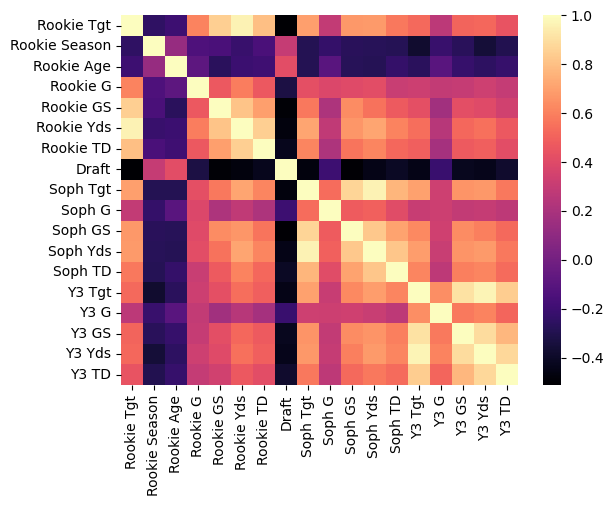

In [406]:
sns.heatmap(X.corr(), cmap='magma')

Taking column names and storing them in a variable for future use.

In [407]:
X_cols = X.columns

Splitting data into training and testing sets.

In [408]:
rs = 59
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rs)

Scaling the data.

In [409]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Checking the distribution of outcomes for the target variable.

<AxesSubplot:xlabel='apy_bucket', ylabel='count'>

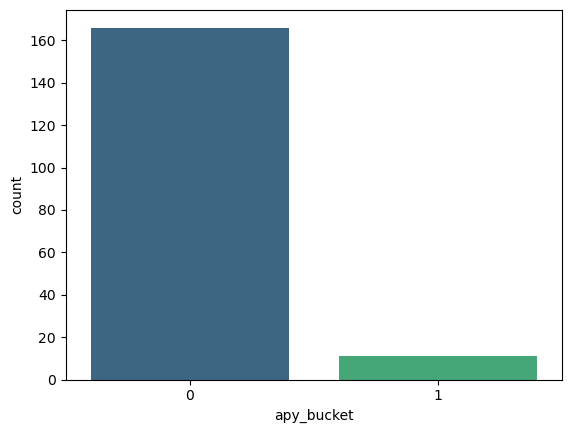

In [410]:
sns.countplot(x=y_train, palette='viridis')

Using SMOTE to oversample our data.

In [411]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train,y_train)

<AxesSubplot:xlabel='apy_bucket', ylabel='count'>

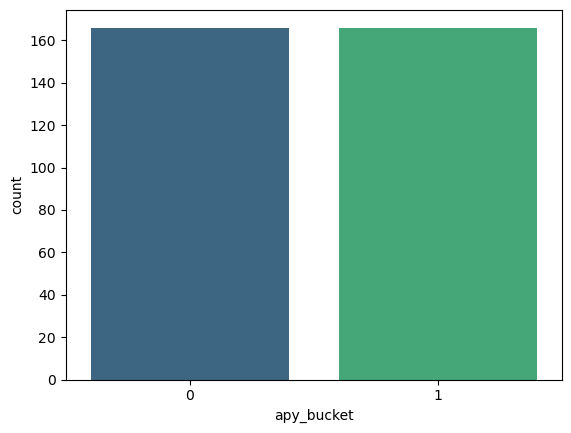

In [412]:
sns.countplot(x=y_train, palette='viridis')

Here we are setting up our GridSearchCV. We are creating a list of our model names, a list of our models, and a list of parameter dictionaries.

In [413]:
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'KNN', 'Naive Bayes', 'Gradient Boosting']
base_models = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), SVC(), KNeighborsClassifier(), 
               GaussianNB(), GradientBoostingClassifier()]
parameters = [
    {'penalty': ['l1', 'l2'], 
              'C': [0.1, 1, 10, 100], 
              'solver': ['liblinear', 'saga']},
    {'criterion': ['gini', 'entropy'], 
              'max_depth': [5, 10, 15, None], 
              'min_samples_split': [2, 5, 10], 
              'min_samples_leaf': [1, 2, 4]},
    {'n_estimators': [50, 100, 200], 
              'criterion': ['gini', 'entropy'], 
              'max_depth': [5, 10, 15, None], 
              'min_samples_split': [2, 5, 10], 
              'min_samples_leaf': [1, 2, 4], 
              'bootstrap': [True, False]},
    {'C': [0.1, 1, 10, 100], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
              'degree': [2, 3, 4], 
              'gamma': ['scale', 'auto']},
    {'n_neighbors': [3, 5, 7, 9], 
              'weights': ['uniform', 'distance'], 
              'algorithm': ['ball_tree', 'kd_tree', 'brute']},
    {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]},
    {'learning_rate': [0.1, 0.05, 0.01], 
              'max_depth': [3, 5, 7], 
              'min_samples_split': [2, 5, 10], 
              'min_samples_leaf': [1, 2, 4], 
              'n_estimators': [100, 200, 500]}
]

We are setting up a for loop to go through our previous lists, and putting a GridSearchCV object for each model type in a new list for us to evaluate.

In [414]:
models = []

for i in range(len(model_names)):
    model = GridSearchCV(base_models[i], parameters[i], n_jobs=-1, scoring='f1', cv=5)
    models.append(model)

Now we loop through each of the GridSearchCV objects and fit it on the training data, using cross-validation to find our best combination of hyperparameters that maximizes F1 score. We then print the confusion matrix and classification report for each model type.

In [415]:
warnings.filterwarnings("ignore")
scores = {}
i = 0

for model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    scores[f'{model_names[i]}'] = accuracy_score(y_test, pred), f1_score(y_test, pred), precision_score(y_test, pred), recall_score(y_test,pred)
    print(f"{model_names[i]}: ")
    print(confusion_matrix(y_test,pred))
    print(classification_report(y_test,pred))
    i += 1

Logistic Regression: 
[[74  4]
 [ 5  5]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94        78
           1       0.56      0.50      0.53        10

    accuracy                           0.90        88
   macro avg       0.75      0.72      0.73        88
weighted avg       0.89      0.90      0.90        88

Decision Tree: 
[[74  4]
 [ 4  6]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        78
           1       0.60      0.60      0.60        10

    accuracy                           0.91        88
   macro avg       0.77      0.77      0.77        88
weighted avg       0.91      0.91      0.91        88

Random Forest: 
[[76  2]
 [ 3  7]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        78
           1       0.78      0.70      0.74        10

    accuracy                           0.94        88
   macro avg     

We then create a DF to more easily visualize our scores and find our best models.

In [416]:
scores_cols = ['Accuracy','F1','Precision','Recall']

scores_df = pd.DataFrame.from_dict(scores, orient='index', columns=scores_cols).sort_values('F1', ascending=False)
scores_df.head()

,Accuracy,F1,Precision,Recall
Random Forest,0.943182,0.736842,0.777778,0.7
Gradient Boosting,0.943182,0.736842,0.777778,0.7
KNN,0.931818,0.727273,0.666667,0.8
SVM,0.943182,0.705882,0.857143,0.6
Naive Bayes,0.897727,0.640000,0.533333,0.8


We've got some pretty good results! Let's look at our Random Forest's most important feature variables.

In [417]:
important_features = models[2].best_estimator_.feature_importances_
indices = np.argsort(important_features)[::-1]
col_names = [X_cols[i] for i in indices]

print("Feature ranking:")
for i in range(X_train.shape[1]):
    print(f"{i+1}. {col_names[i]} ({important_features[indices[i]]})")

Feature ranking:
1. Soph Yds (0.20086799792263835)
2. Soph GS (0.1412167334352073)
3. Soph Tgt (0.14033403944725478)
4. Rookie TD (0.08395280616587648)
5. Rookie Yds (0.0803046544189377)
6. Soph TD (0.06452587827862706)
7. Y3 GS (0.05928441345718976)
8. Y3 Yds (0.05194701991499513)
9. Draft (0.04050172193030342)
10. Y3 TD (0.04025923333265597)
11. Y3 Tgt (0.027926751628517953)
12. Rookie Tgt (0.021843610104638547)
13. Soph G (0.013445440378730496)
14. Rookie Season (0.011729416985741717)
15. Y3 G (0.007224202126161143)
16. Rookie Age (0.005500070713211288)
17. Rookie GS (0.005443470859822364)
18. Rookie G (0.0036925388994907223)


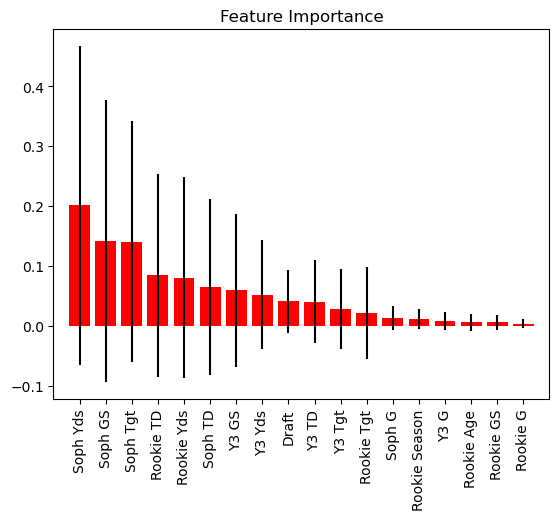

In [418]:
std = np.std([tree.feature_importances_ for tree in models[2].best_estimator_.estimators_], axis=0)
plt.figure()
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), important_features[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation='vertical')
plt.xlim([-1, X_train.shape[1]])

plt.show()

Let's see if we can get better results with a more simplified model, using our 8 most important variables.

In [419]:
X = X[col_names[:8]]

In [420]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rs)

In [421]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [422]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train,y_train)

In [423]:
warnings.filterwarnings("ignore")
scores = {}
i = 0

for model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    scores[f'{model_names[i]}'] = accuracy_score(y_test, pred), f1_score(y_test, pred), precision_score(y_test, pred), recall_score(y_test,pred)
    print(f"{model_names[i]}: ")
    print(confusion_matrix(y_test,pred))
    print(classification_report(y_test,pred))
    i += 1

Logistic Regression: 
[[73  5]
 [ 2  8]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        78
           1       0.62      0.80      0.70        10

    accuracy                           0.92        88
   macro avg       0.79      0.87      0.82        88
weighted avg       0.93      0.92      0.92        88

Decision Tree: 
[[75  3]
 [ 5  5]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        78
           1       0.62      0.50      0.56        10

    accuracy                           0.91        88
   macro avg       0.78      0.73      0.75        88
weighted avg       0.90      0.91      0.90        88

Random Forest: 
[[75  3]
 [ 2  8]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97        78
           1       0.73      0.80      0.76        10

    accuracy                           0.94        88
   macro avg     

In [424]:
scores_cols = ['Accuracy','F1','Precision','Recall']

scores_df = pd.DataFrame.from_dict(scores, orient='index', columns=scores_cols).sort_values('F1', ascending=False)
scores_df.head()

,Accuracy,F1,Precision,Recall
SVM,0.965909,0.823529,1.000000,0.7
Random Forest,0.943182,0.761905,0.727273,0.8
Logistic Regression,0.920455,0.695652,0.615385,0.8
Naive Bayes,0.909091,0.666667,0.571429,0.8
KNN,0.920455,0.631579,0.666667,0.6


It seems our results have improved! We were able to slightly increase our F1 score for our Random Forest, and improved our SVM model significantly to be our best performing model. The hyperparameters used are below.

In [430]:
models[3].best_estimator_

SVC(C=10, degree=4, kernel='poly')

https://overthecap.com/contract-history/wide-receiver

https://stathead.com/football/player-season-finder.cgi